In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

## Result Gathering

In [95]:
main_df = None
directory = "Effort_Estimation_Results_v4/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cxf.csv
Dbeaver.csv
Hadoop.csv
Okhttp.csv
Redisson.csv


In [96]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_dependency_max,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std
0,3,19.225678,1.0,167.0,1.0,2.0,2.0,3.0,4.0,7.0,...,177.0,93.543216,458.666667,24,1245,682.248,35.0,1,54,29.512709
1,3,19.225678,1.0,167.0,1.0,2.0,2.0,3.0,4.0,7.0,...,95.0,41.719300,242.000000,242,242,0.000,4.0,4,4,0.000000
2,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,85.0,NaN,61.000000,61,61,NaN,2.0,2,2,NaN
3,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,3.0,NaN,78.000000,78,78,NaN,1.0,1,1,NaN
4,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,78.0,0.000000,322.000000,322,322,0.000,1.5,1,2,0.707107


In [97]:
len(main_df)

366

In [98]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return

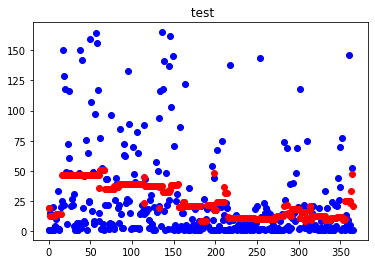

In [99]:
plotGraph(main_df['time_taken'], main_df['time_taken_mean'],' test')

In [100]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [101]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



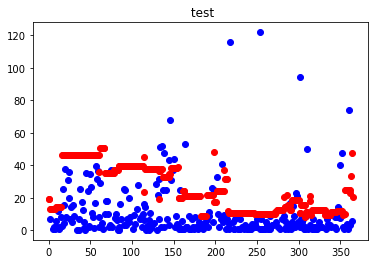

In [103]:
plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

In [107]:
main_df = main_df[main_df['time_taken_final'] <= 60]
main_df = main_df[main_df['time_taken_final'] > 2]

In [108]:
main_df['time_taken_final'].value_counts()

7.0     19
3.0     14
5.0     12
4.0      8
9.0      7
        ..
7.4      1
12.4     1
2.6      1
17.6     1
35.6     1
Name: time_taken_final, Length: 88, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1983eac3fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1983ead2748>,
 'boxes': [<matplotlib.lines.Line2D at 0x1983eac3e80>],
 'medians': [<matplotlib.lines.Line2D at 0x1983ead2e48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1983eadb208>],
 'means': []}

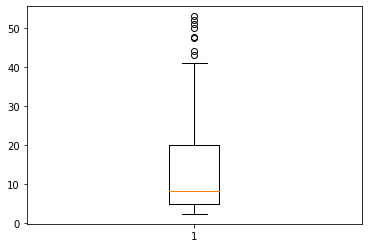

In [109]:
plt.boxplot(main_df['time_taken_final'])

In [110]:
main_df = main_df.fillna(0)

In [143]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,time_taken_final
2,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,0.000000,61.00,61,61,0.000000,2.000000,2,2,0.000000,7.0
9,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,0.000000,764.00,764,764,0.000000,9.000000,9,9,0.000000,6.0
11,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,0.000000,115.00,115,115,0.000000,4.500000,3,6,2.121320,12.0
15,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,0.000000,47.00,47,47,0.000000,9.333333,1,14,7.234178,8.0
0,1,46.327198,1.0,167.0,2.0,6.6,11.0,16.0,22.2,28.0,...,4.949747,119.50,64,175,78.488853,68.500000,59,78,13.435029,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,8,12.012698,1.0,167.0,1.0,1.0,2.0,2.0,3.0,4.0,...,0.000000,411.00,411,411,0.000000,1.000000,1,1,0.000000,47.4
1,6,24.722772,1.0,148.0,2.0,3.0,4.0,6.0,10.4,14.0,...,7.365460,366.75,128,907,362.783108,5.000000,2,8,2.581989,2.6
2,7,24.990354,1.0,167.0,1.0,2.0,3.0,5.0,8.0,12.0,...,157.684284,323.25,71,571,281.001038,20.750000,2,40,15.649814,4.0
6,11,23.121622,1.0,162.0,1.0,2.0,3.0,4.0,6.0,8.0,...,3.535534,24.00,15,33,12.727922,3.500000,1,6,3.535534,3.0


In [112]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [113]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [114]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [115]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with','actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
                 'num_dependency_min',
                  'num_dependency_max',
                  'num_dependency_std',
                 'num_line_affected_min',
                 'num_line_affected_max',
                 'num_line_affected_std']
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [116]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [117]:
X_col = final_col.copy()
X_col.remove('time_taken_final')
Y_col = ['time_taken_final']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [118]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
2,11.0,11.0,11.0,0.00000,8.0,8.0,8.0,0.000000,2.0,2.0,...,58.0,58.0,58.0,0.00000,17.0,17.0,17.0,0.0,85.0,61.0
9,38.0,38.0,38.0,0.00000,57.0,57.0,57.0,0.000000,1.0,1.0,...,279.0,279.0,279.0,0.00000,17.0,17.0,17.0,0.0,322.0,764.0
11,4.0,4.0,4.0,0.00000,15.0,15.0,15.0,0.000000,1.0,1.0,...,108.0,108.0,108.0,0.00000,1.0,1.0,1.0,0.0,371.0,115.0
15,3.0,3.0,3.0,0.00000,5.0,5.0,5.0,0.000000,1.0,1.0,...,38.0,38.0,38.0,0.00000,16.0,16.0,16.0,0.0,23.0,47.0
0,21.5,20.0,23.0,2.12132,9.0,6.0,12.0,4.242641,3.0,3.0,...,68.0,54.0,82.0,19.79899,0.0,0.0,0.0,0.0,12.5,119.5


In [119]:
y.head()

,time_taken_final
2,7.0
9,6.0
11,12.0
15,8.0
0,2.8


In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [121]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 52 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 2 days
H2O_cluster_name:,H2O_from_python_tanji_k06gu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.888 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [122]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "time_taken_final"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [123]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [124]:
train[y].types

{'time_taken_final': 'real'}

In [125]:
aml = H2OAutoML(max_models=10, seed=16, exclude_algos=['XGBoost', 'GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████
02:33:29.677: Skipping training of model GBM_5_AutoML_20211205_023323 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20211205_023323.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 117.0.


█████████████████████████████████████████████████| 100%


In [126]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20211205_023323,168.467,12.9795,168.467,10.3551,0.811791
DRF_1_AutoML_20211205_023323,168.934,12.9975,168.934,10.1108,0.807144
StackedEnsemble_BestOfFamily_AutoML_20211205_023323,169.686,13.0264,169.686,10.3403,0.812443
GBM_grid__1_AutoML_20211205_023323_model_2,174.088,13.1942,174.088,10.2106,0.801768
GBM_1_AutoML_20211205_023323,176.14,13.2718,176.14,10.2421,0.795388
GBM_4_AutoML_20211205_023323,176.301,13.2779,176.301,10.4235,0.82786
GBM_3_AutoML_20211205_023323,180.817,13.4468,180.817,10.7252,0.852391
XRT_1_AutoML_20211205_023323,181.731,13.4807,181.731,10.6738,0.840065
GBM_2_AutoML_20211205_023323,182.253,13.5001,182.253,10.7936,0.852158
GBM_grid__1_AutoML_20211205_023323_model_1,182.477,13.5084,182.477,10.8274,0.857199


In [127]:
model = h2o.get_model(lb[0,'model_id'])

In [128]:
model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20211205_023323

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 80.56491811371963
RMSE: 8.975796238424735
MAE: 7.2009679902647195
RMSLE: 0.6017676906860303
R^2: 0.52241118851467
Mean Residual Deviance: 80.56491811371963
Null degrees of freedom: 116
Residual degrees of freedom: 111
Null deviance: 19736.843059596547
Residual deviance: 9426.095419305197
AIC: 859.5520223579994

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 168.46660214552588
RMSE: 12.979468484707912
MAE: 10.355104856538361
RMSLE: 0.8117907230428149
R^2: 0.0013300307699032343
Mean Residual Deviance: 168.46660214552588
Null degrees of freedom: 116
Residual degrees of freedom: 111
Null deviance: 20009.65322487023
Residual deviance: 19710.59245102653
AIC: 945.859906995451


In [129]:
preds = model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [130]:
preds

predict
16.5844
20.4663
14.5345
11.8399
13.9217
15.2367
14.6979
15.0205
11.8685
15.0096


In [131]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

14.675300    1
15.605937    1
15.796652    1
14.540254    1
13.296382    1
14.534497    1
16.978731    1
14.241284    1
17.442457    1
15.976524    1
13.812352    1
12.530216    1
14.057606    1
16.584359    1
14.129609    1
11.868525    1
12.442793    1
13.492521    1
14.697919    1
11.861107    1
13.823358    1
17.239134    1
15.009647    1
12.035568    1
14.396086    1
16.653424    1
15.910997    1
15.236683    1
11.841764    1
18.670180    1
21.172120    1
15.020462    1
13.987410    1
14.223704    1
12.651542    1
12.043219    1
11.865943    1
14.978183    1
17.589703    1
13.921729    1
18.215266    1
20.466325    1
14.427684    1
15.430013    1
14.885811    1
12.349282    1
11.839860    1
12.135410    1
12.752347    1
18.129427    1
12.315859    1
20.672428    1
Name: predict, dtype: int64

In [132]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,time_taken_final
38,38,38,0,57,57,57,0,1,1,1,0,81,81,81,0,0,0,0,0,45,45,45,0,1,1,1,0,42,42,42,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,1,1,1,0,0,0,0,0,12,12,12,0,0,0,0,0,0,0,0,0,5,5,5,0,0,0,0,0,32,32,32,0,576,576,576,0,2,2,2,0,6,6,6,0,1,1,1,0,5,5,5,0,26,26,26,0,13,13,13,0,159,159,159,0,100,100,100,0,85,85,85,0,90,90,90,0,1,1,1,0,2,2,2,0,0,0,0,0,2,2,2,0,279,279,279,0,17,17,17,0,322,764,6
4,4,4,0,15,15,15,0,1,1,1,0,6,6,6,0,18,18,18,0,12,12,12,0,1,1,1,0,11,11,11,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,64,64,64,0,12,12,12,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,7,7,7,0,0,0,0,0,4,4,4,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,108,108,108,0,1,1,1,0,371,115,12
3,3,3,0,5,5,5,0,1,1,1,0,5,5,5,0,2,2,2,0,5,5,5,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,5,5,5,0,33,33,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,38,38,38,0,16,16,16,0,23,47,8
21.5,20,23,2.12132,9,6,12,4.24264,3,3,3,0,25,15,35,14.1421,37.5,15,60,31.8198,9,6,12,4.24264,3.5,0,7,4.94975,0,0,0,0,3.5,0,7,4.94975,0.5,0,1,0.7071

{'whiskers': [<matplotlib.lines.Line2D at 0x1983eea7358>,
 'caps': [<matplotlib.lines.Line2D at 0x1983eea7a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1983eea7208>],
 'medians': [<matplotlib.lines.Line2D at 0x1983eecd1d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1983eecd550>],
 'means': []}

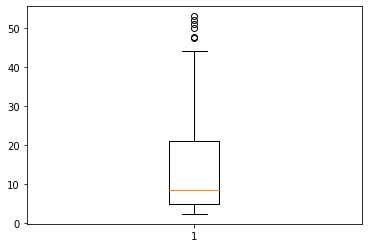

In [133]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['time_taken_final'])

In [147]:
len(main_df['actual_num_of_classes_touched_max'])

169

In [149]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

166

In [150]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

155

In [151]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

143

In [152]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

126

In [153]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

95

{'whiskers': [<matplotlib.lines.Line2D at 0x19840230198>,
 'caps': [<matplotlib.lines.Line2D at 0x198402308d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x19840230048>],
 'medians': [<matplotlib.lines.Line2D at 0x19840230f98>],
 'fliers': [<matplotlib.lines.Line2D at 0x19840237320>],
 'means': []}

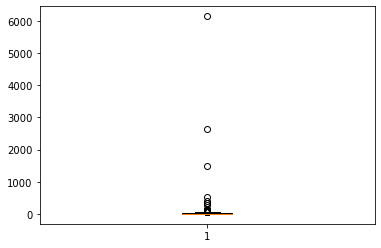

In [142]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [144]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x1983bb6ee48>,
 'caps': [<matplotlib.lines.Line2D at 0x19838689da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1983bb6e3c8>],
 'medians': [<matplotlib.lines.Line2D at 0x19838689358>],
 'fliers': [<matplotlib.lines.Line2D at 0x19838689668>],
 'means': []}

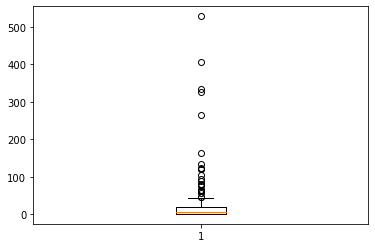

In [145]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1983854ac18>,
 'caps': [<matplotlib.lines.Line2D at 0x1983852cf28>,
 'boxes': [<matplotlib.lines.Line2D at 0x19838541e80>],
 'medians': [<matplotlib.lines.Line2D at 0x1983852ccc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x198385cb358>],
 'means': []}

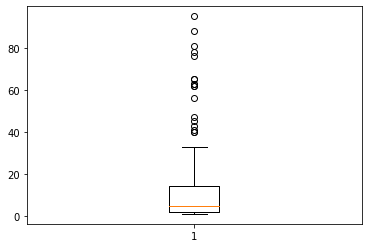

In [146]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [134]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['time_taken_final']

In [135]:
pd_preds

,predict,actual_time_taken
0,16.584359,7.0
1,20.466325,8.0
2,14.534497,31.0
3,11.839860,25.6
4,13.921729,17.6
5,15.236683,5.0
6,14.697919,35.0
7,15.020462,2.8
8,11.868525,36.6
9,15.009647,3.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1983feee128>,
 'caps': [<matplotlib.lines.Line2D at 0x1983feee860>,
 'boxes': [<matplotlib.lines.Line2D at 0x1983fedff98>],
 'medians': [<matplotlib.lines.Line2D at 0x1983feeef28>],
 'fliers': [<matplotlib.lines.Line2D at 0x1983fef72e8>],
 'means': []}

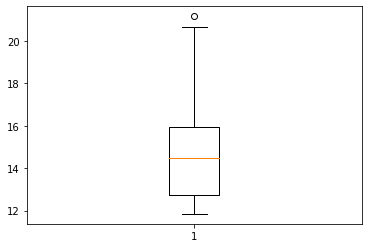

In [136]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1983ff477f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1983ff47f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x1983ff476a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1983ff52668>],
 'fliers': [<matplotlib.lines.Line2D at 0x1983ff529e8>],
 'means': []}

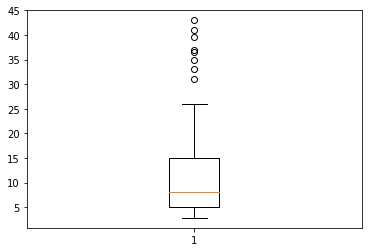

In [137]:
plt.boxplot(pd_preds['actual_time_taken'])

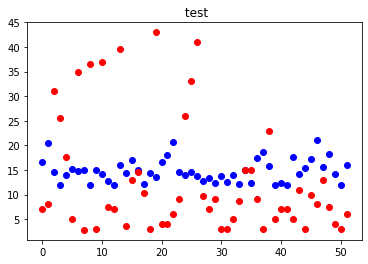

In [138]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],' test')

In [139]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

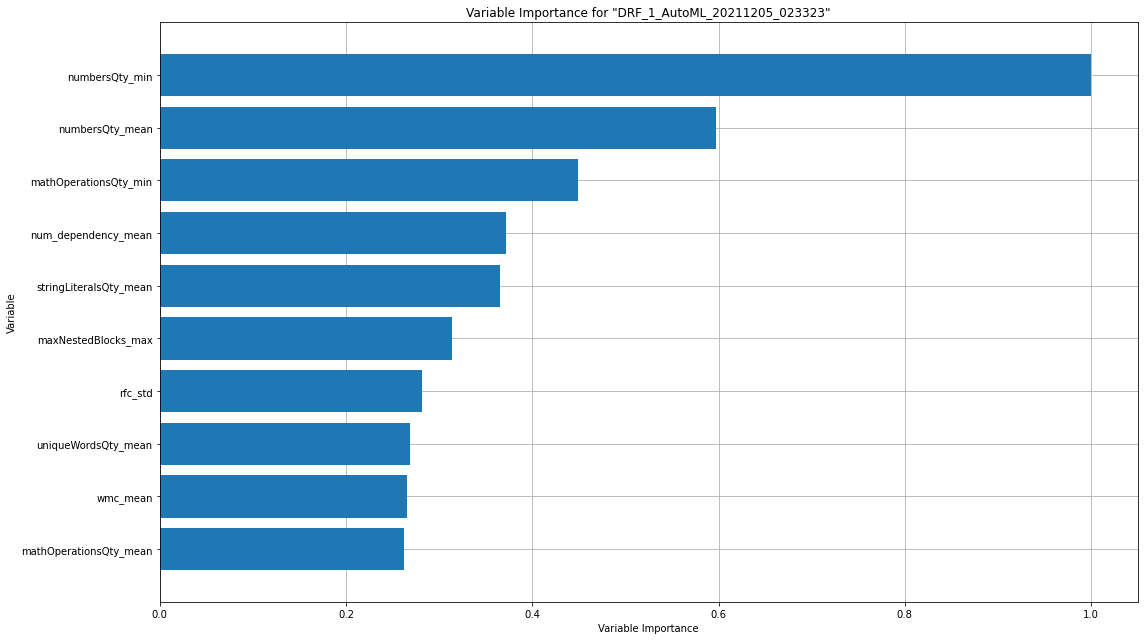

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

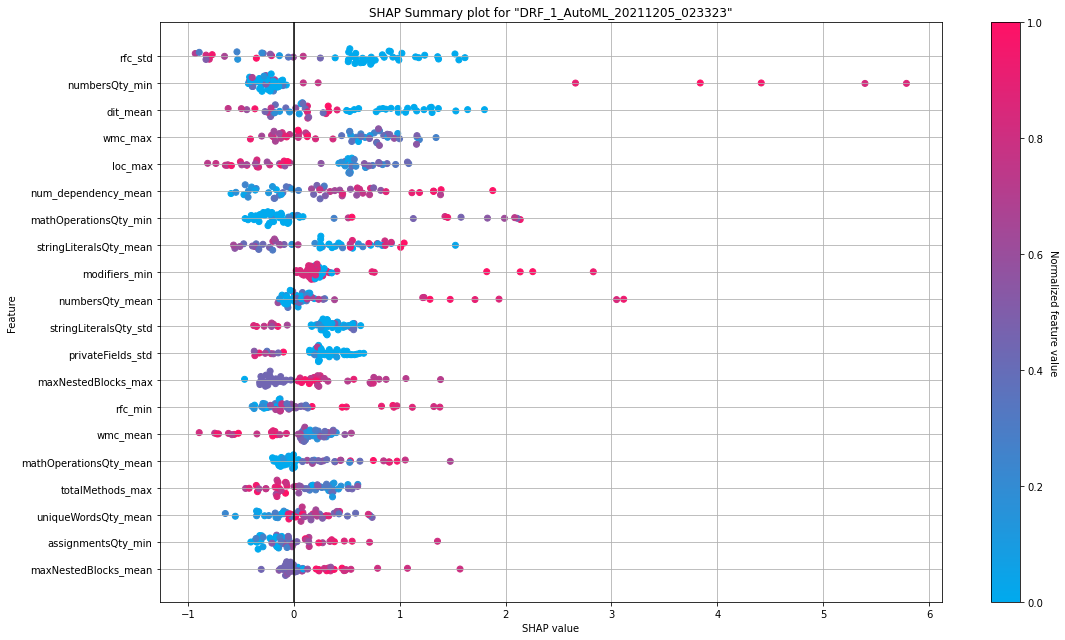

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

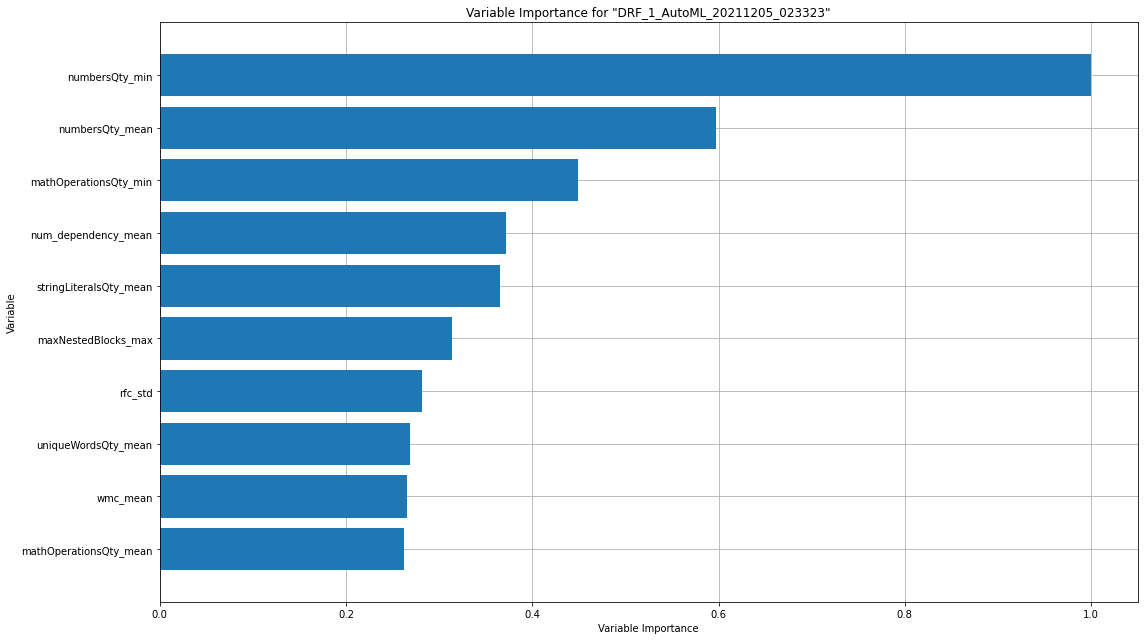

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

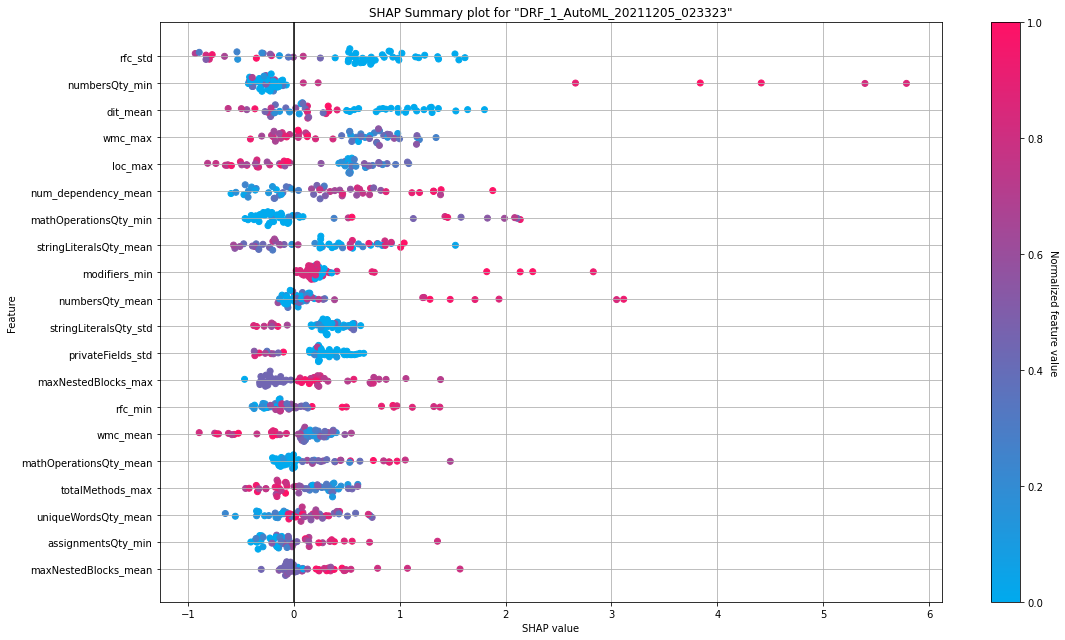

In [140]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [65]:
#aml.explain_row(test, row_index=0)

In [66]:
#h2o.shutdown()